In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# load dataset and inspect it 
base_path = r"C:\Users\geniu\OneDrive\Desktop\computer science thesis\dataset"
file_path = os.path.join(base_path, "data.csv")
df = pd.read_csv(file_path)
from sklearn.model_selection import train_test_split

# Set your target column name here
target_column = 'Adherent'

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Step 1: Split off 20% test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
# Step 2: Split remaining 80% → 70% train, 10% validation
# 10% out of original = 12.5% of remaining
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)
# Confirm shapes
print(f"Train:      {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test:       {X_test.shape}, {y_test.shape}")
# Make copies so we can safely preprocess
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()
X_test_processed = X_test.copy()
# Binary encoding: 1 = has NHIA, 0 = missing (uninsured)
X_train_processed['insurance_status'] = X_train_processed['NHIA No.'].notna().astype(int)
X_val_processed['insurance_status'] = X_val_processed['NHIA No.'].notna().astype(int)
X_test_processed['insurance_status'] = X_test_processed['NHIA No.'].notna().astype(int)

X_train_processed.drop(columns=['NHIA No.'], inplace=True)
X_val_processed.drop(columns=['NHIA No.'], inplace=True)
X_test_processed.drop(columns=['NHIA No.'], inplace=True)
# First, normalize the Gender column to lowercase
X_train_processed['Gender'] = X_train_processed['Gender'].str.lower()
X_val_processed['Gender'] = X_val_processed['Gender'].str.lower()
X_test_processed['Gender'] = X_test_processed['Gender'].str.lower()

# Then apply binary encoding
gender_map = {'female': 0, 'male': 1}
X_train_processed['gender_encoded'] = X_train_processed['Gender'].map(gender_map)
X_val_processed['gender_encoded'] = X_val_processed['Gender'].map(gender_map)
X_test_processed['gender_encoded'] = X_test_processed['Gender'].map(gender_map)

# Filter out patients younger than 18
age_mask_train = X_train_processed['Age'] >= 18
X_train_processed = X_train_processed[age_mask_train]
y_train = y_train.loc[X_train_processed.index]

age_mask_val = X_val_processed['Age'] >= 18
X_val_processed = X_val_processed[age_mask_val]
y_val = y_val.loc[X_val_processed.index]
age_mask_test = X_test_processed['Age'] >= 18
X_test_processed = X_test_processed[age_mask_test]
y_test = y_test.loc[X_test_processed.index]
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set only
X_train_processed['age_scaled'] = scaler.fit_transform(X_train_processed[['Age']])

# Apply to validation and test
X_val_processed['age_scaled'] = scaler.transform(X_val_processed[['Age']])
X_test_processed['age_scaled'] = scaler.transform(X_test_processed[['Age']])
chronic_conditions = ['diabetes', 'hyperlipidemia','hyperlipidaemia','heart failure', 'stroke', 'atherosclerosis']

def has_chronic_condition(text):
    if pd.isna(text):
        return 0
    text = text.lower()
    return int(any(condition in text for condition in chronic_conditions))

X_train_processed['has_chronic_comorbidity'] = X_train_processed['Additional Diagnosis (New Case)'].apply(has_chronic_condition)
X_val_processed['has_chronic_comorbidity'] = X_val_processed['Additional Diagnosis (New Case)'].apply(has_chronic_condition)
X_test_processed['has_chronic_comorbidity'] = X_test_processed['Additional Diagnosis (New Case)'].apply(has_chronic_condition)
# Drop rows where total_meds_count is zero — they likely indicate missing or invalid data

train_mask = X_train_processed['total_count'] > 0
X_train_processed = X_train_processed[train_mask]
y_train = y_train.loc[X_train_processed.index]
val_mask = X_val_processed['total_count'] > 0
X_val_processed = X_val_processed[val_mask]
y_val = y_val.loc[X_val_processed.index]

test_mask = X_test_processed['total_count'] > 0
X_test_processed = X_test_processed[test_mask]
y_test = y_test.loc[X_test_processed.index]

# Standardize the estimated price
price_scaler = StandardScaler()
X_train_processed['estimated_price_scaled'] = price_scaler.fit_transform(X_train_processed[['estimated_price']])
X_val_processed['estimated_price_scaled'] = price_scaler.transform(X_val_processed[['estimated_price']])
X_test_processed['estimated_price_scaled'] = price_scaler.transform(X_test_processed[['estimated_price']])


Train:      (1367, 13), (1367,)
Validation: (196, 13), (196,)
Test:       (391, 13), (391,)


In [5]:
df['Adherent'].value_counts(normalize =True) * 100

Adherent
1    74.411464
0    25.588536
Name: proportion, dtype: float64

In [6]:
selected_features = ['insurance_status', 'gender_encoded', 'age_scaled',
       'has_chronic_comorbidity', 'estimated_price_scaled', 'total_count']

In [7]:
X_train_first = X_train_processed[selected_features]
X_val_first = X_val_processed[selected_features]
X_test_first = X_test_processed[selected_features]


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_first)
y_val_proba = logreg.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Logistic Regression Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8939393939393939
Recall   : 0.9365079365079365
F1 Score : 0.9147286821705426
ROC AUC  : 0.9171957671957672

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.69      0.74        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.81      0.83       171
    weighted avg       0.87      0.87      0.87       171



In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_first)
y_val_proba_rf = rf_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Random Forest Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.905511811023622
Recall   : 0.9126984126984127
F1 Score : 0.9090909090909091
ROC AUC  : 0.897089947089947

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.75      0.73      0.74        45
    Adherent (1)       0.91      0.91      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.82      0.83       171
    weighted avg       0.86      0.87      0.87       171



In [10]:
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_first)
y_val_proba_xgb = xgb_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 XGBoost Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.8993827160493827

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
from sklearn.svm import SVC

# Initialize and train
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_first)
y_val_proba_svm = svm_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 SVM (RBF) Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8872180451127819
Recall   : 0.9365079365079365
F1 Score : 0.9111969111969112
ROC AUC  : 0.8753968253968254

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.67      0.72        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.80      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [12]:
from sklearn.neural_network import MLPClassifier

# Initialize and train
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_first)
y_val_proba_mlp = mlp_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Neural Network (MLP) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Neural Network (MLP) Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.9
Recall   : 0.9285714285714286
F1 Score : 0.9140625
ROC AUC  : 0.9078483245149912

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.71      0.74        45
    Adherent (1)       0.90      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.82      0.83       171
    weighted avg       0.87      0.87      0.87       171



C:\Users\geniu\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


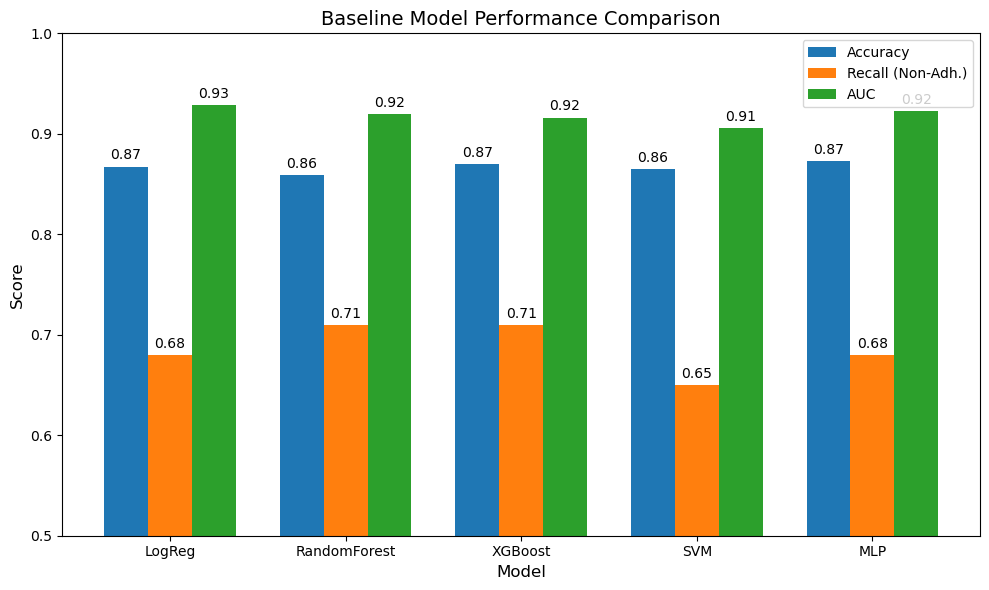

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LogReg', 'RandomForest', 'XGBoost', 'SVM', 'MLP']

# Metrics based on your latest test results
accuracy = [0.8674, 0.8591, 0.8702, 0.8646, 0.8729]
recall_nonadherent = [0.68, 0.71, 0.71, 0.65, 0.68]
auc = [0.9290, 0.9194, 0.9162, 0.9055, 0.9228]

# Set up bar width and positions
x = np.arange(len(models))
bar_width = 0.25

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric
bar1 = ax.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy')
bar2 = ax.bar(x, recall_nonadherent, width=bar_width, label='Recall (Non-Adh.)')
bar3 = ax.bar(x + bar_width, auc, width=bar_width, label='AUC')

# Add labels and formatting
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline Model Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0.5, 1.0)

# Annotate bars with values
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


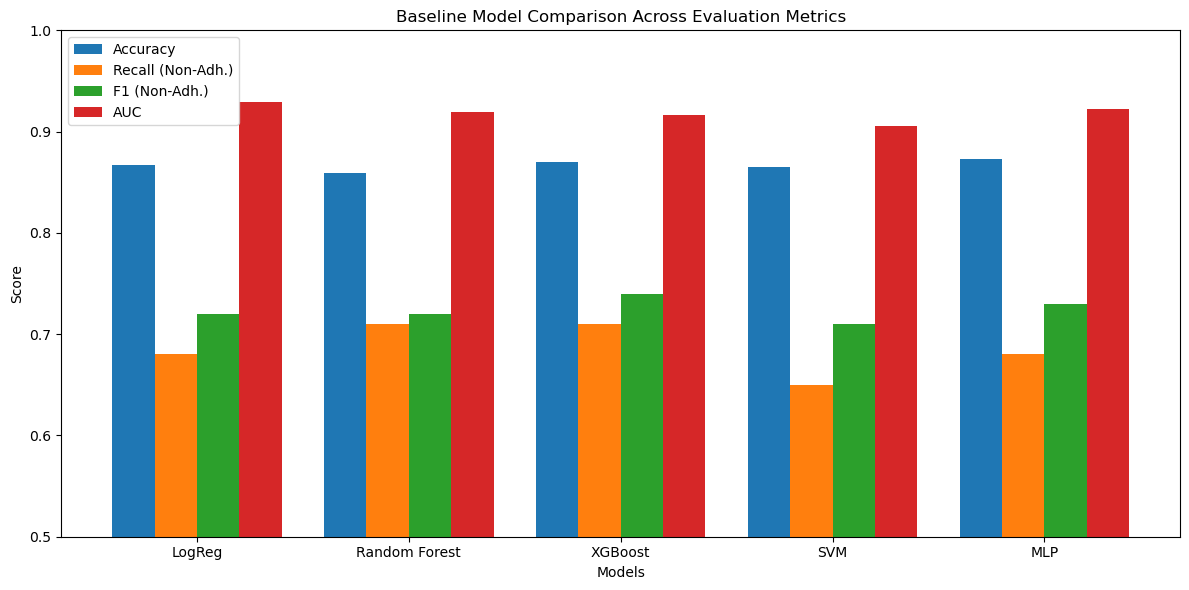

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LogReg', 'Random Forest', 'XGBoost', 'SVM', 'MLP']

# Metrics (based on earlier shared results)
accuracy = [0.8674, 0.8591, 0.8702, 0.8646, 0.8729]
recall_non_adherent = [0.68, 0.71, 0.71, 0.65, 0.68]
f1_non_adherent = [0.72, 0.72, 0.74, 0.71, 0.73]
auc = [0.9290, 0.9194, 0.9162, 0.9055, 0.9228]

# Bar width and index
bar_width = 0.2
index = np.arange(len(models))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, recall_non_adherent, bar_width, label='Recall (Non-Adh.)')
plt.bar(index + 2*bar_width, f1_non_adherent, bar_width, label='F1 (Non-Adh.)')
plt.bar(index + 3*bar_width, auc, bar_width, label='AUC')

# Aesthetics
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Baseline Model Comparison Across Evaluation Metrics')
plt.xticks(index + 1.5*bar_width, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()

plt.show()


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Set up grid search
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1', 
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_xgb.fit(X_train_first, y_train)
# Best model
best_xgb = grid_xgb.best_estimator_
# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val_first)
y_val_proba_xgb = best_xgb.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned XGBoost Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.905511811023622
Recall   : 0.9126984126984127
F1 Score : 0.9090909090909091
ROC AUC  : 0.9175485008818343

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.75      0.73      0.74        45
    Adherent (1)       0.91      0.91      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.82      0.83       171
    weighted avg       0.86      0.87      0.87       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

def evaluate_model(model, X, y_true, model_name="Model"):
    # Get predicted labels and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
  # Print results
    print(f"📈 {model_name} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Set up grid search
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1
)

# Fit on training data
grid_logreg.fit(X_train_first, y_train)

# Best model
best_logreg = grid_logreg.best_estimator_
# Predict on validation set
y_val_pred_logreg = best_logreg.predict(X_val_first)
y_val_proba_logreg = best_logreg.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned Logistic Regression Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8939393939393939
Recall   : 0.9365079365079365
F1 Score : 0.9147286821705426
ROC AUC  : 0.9171957671957672

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.69      0.74        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.81      0.83       171
    weighted avg       0.87      0.87      0.87       171



In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_rf.fit(X_train_first, y_train)
# Best model
best_rf = grid_rf.best_estimator_
# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val_first)
y_val_proba_rf = best_rf.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Tuned Random Forest Performance on Validation Set:
Accuracy : 0.8771929824561403
Precision: 0.9007633587786259
Recall   : 0.9365079365079365
F1 Score : 0.9182879377431906
ROC AUC  : 0.9156966490299823

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.71      0.75        45
    Adherent (1)       0.90      0.94      0.92       126

        accuracy                           0.88       171
       macro avg       0.85      0.82      0.84       171
    weighted avg       0.87      0.88      0.87       171



In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

# Set up grid search
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_svm.fit(X_train_first, y_train)
# Best model
best_svm = grid_svm.best_estimator_
# Predict on validation set
y_val_pred_svm = best_svm.predict(X_val_first)
y_val_proba_svm = best_svm.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned SVM (RBF) Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8872180451127819
Recall   : 0.9365079365079365
F1 Score : 0.9111969111969112
ROC AUC  : 0.8753968253968254

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.67      0.72        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.80      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# Set up grid search
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned MLP Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8880597014925373
Recall   : 0.9444444444444444
F1 Score : 0.9153846153846154
ROC AUC  : 0.9087301587301587

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.67      0.73        45
    Adherent (1)       0.89      0.94      0.92       126

        accuracy                           0.87       171
       macro avg       0.85      0.81      0.82       171
    weighted avg       0.87      0.87      0.87       171



In [21]:
# Evaluate
evaluate_model(best_mlp, X_test_first, y_test, model_name=" Tuned MLP")

📈  Tuned MLP Performance:
Accuracy : 0.8785
Precision: 0.9004
Recall   : 0.9405
F1 Score : 0.9200
ROC AUC  : 0.9319

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.70      0.75        93
    Adherent (1)       0.90      0.94      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.82      0.83       362
    weighted avg       0.88      0.88      0.88       362



In [22]:
# Evaluate
evaluate_model(best_xgb, X_test_first, y_test, model_name="Tuned XGBoost")

📈 Tuned XGBoost Performance:
Accuracy : 0.8840
Precision: 0.9127
Recall   : 0.9331
F1 Score : 0.9228
ROC AUC  : 0.9404

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.74      0.77        93
    Adherent (1)       0.91      0.93      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.84      0.84       362
    weighted avg       0.88      0.88      0.88       362



In [23]:
# Evaluate
evaluate_model(best_logreg, X_test_first, y_test, model_name="Tuned Logistic Regression")

📈 Tuned Logistic Regression Performance:
Accuracy : 0.8757
Precision: 0.9000
Recall   : 0.9368
F1 Score : 0.9180
ROC AUC  : 0.9322

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.70      0.74        93
    Adherent (1)       0.90      0.94      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.82      0.83       362
    weighted avg       0.87      0.88      0.87       362



In [24]:
# Evaluate
evaluate_model(best_rf, X_test_first, y_test, model_name="Tuned RF")

📈 Tuned RF Performance:
Accuracy : 0.8812
Precision: 0.9124
Recall   : 0.9294
F1 Score : 0.9208
ROC AUC  : 0.9277

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.74      0.76        93
    Adherent (1)       0.91      0.93      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.84      0.84       362
    weighted avg       0.88      0.88      0.88       362



In [25]:
# Evaluate
evaluate_model(best_svm, X_test_first, y_test, model_name="Tuned SVM")

📈 Tuned SVM Performance:
Accuracy : 0.8702
Precision: 0.8964
Recall   : 0.9331
F1 Score : 0.9144
ROC AUC  : 0.9104

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        93
    Adherent (1)       0.90      0.93      0.91       269

        accuracy                           0.87       362
       macro avg       0.84      0.81      0.82       362
    weighted avg       0.87      0.87      0.87       362



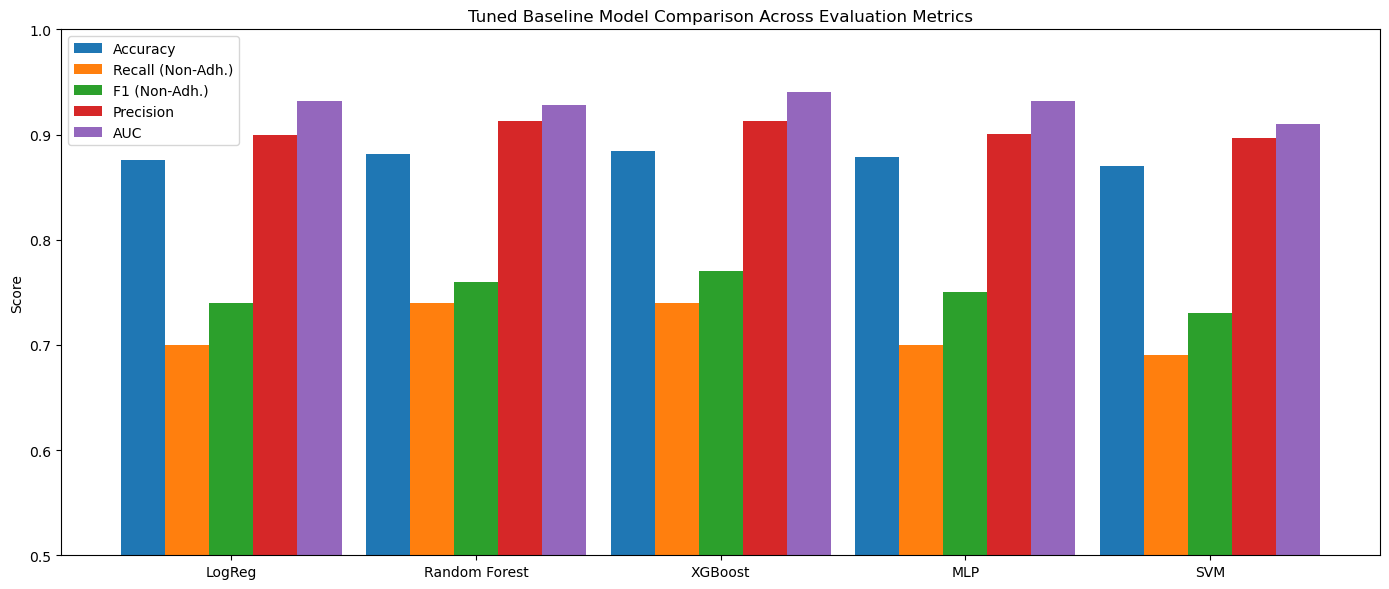

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Tuned model names
models = ['LogReg', 'Random Forest', 'XGBoost', 'MLP', 'SVM']

# Corresponding metrics for each model
accuracy = [0.8757, 0.8812, 0.8840, 0.8785, 0.8702]
recall_non_adh = [0.70, 0.74, 0.74, 0.70, 0.69]
f1_non_adh = [0.74, 0.76, 0.77, 0.75, 0.73]
precision = [0.9000, 0.9124, 0.9127, 0.9004, 0.8964]
auc = [0.9322, 0.9277, 0.9404, 0.9319, 0.9104]

# Bar plot setup
x = np.arange(len(models))
width = 0.18

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - width, recall_non_adh, width, label='Recall (Non-Adh.)')
bars3 = ax.bar(x, f1_non_adh, width, label='F1 (Non-Adh.)')
bars4 = ax.bar(x + width, precision, width, label='Precision')
bars5 = ax.bar(x + 2*width, auc, width, label='AUC')

# Formatting
ax.set_ylabel('Score')
ax.set_title('Tuned Baseline Model Comparison Across Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([0.5, 1.0])
ax.legend()

plt.tight_layout()
plt.show()


In [27]:
from sklearn.ensemble import VotingClassifier

# Create Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    voting='soft',  # Use probability-based soft voting
)


# Fit on training data
voting_clf.fit(X_train_first, y_train)

# Evaluate
evaluate_model(voting_clf, X_val_first, y_val, model_name="Voting Ensemble")

C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Voting Ensemble Performance:
Accuracy : 0.8772
Precision: 0.9008
Recall   : 0.9365
F1 Score : 0.9183
ROC AUC  : 0.9177

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.71      0.75        45
    Adherent (1)       0.90      0.94      0.92       126

        accuracy                           0.88       171
       macro avg       0.85      0.82      0.84       171
    weighted avg       0.87      0.88      0.87       171



In [28]:
# Evaluate
evaluate_model(voting_clf, X_test_first, y_test, model_name="Voting Ensemble")

📈 Voting Ensemble Performance:
Accuracy : 0.8923
Precision: 0.9197
Recall   : 0.9368
F1 Score : 0.9282
ROC AUC  : 0.9367

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.76      0.78        93
    Adherent (1)       0.92      0.94      0.93       269

        accuracy                           0.89       362
       macro avg       0.86      0.85      0.86       362
    weighted avg       0.89      0.89      0.89       362



In [29]:
from sklearn.ensemble import StackingClassifier

# Define base learners
base_learners = [
   ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('rf', best_rf)
]

# Define final estimator
final_estimator = LogisticRegression()
# Build stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5
)
# Fit on training data
stacked_clf.fit(X_train_first, y_train)
# Predict and evaluate on validation set
y_val_pred = stacked_clf.predict(X_val_first)
y_val_proba = stacked_clf.predict_proba(X_val_first)[:, 1]
# Evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)
# Print results
print("📈 Stacking Ensemble Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))


C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\

📈 Stacking Ensemble Performance:
Accuracy : 0.8772
Precision: 0.8947
Recall   : 0.9444
F1 Score : 0.9189
ROC AUC  : 0.9168

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.82      0.69      0.75        45
    Adherent (1)       0.89      0.94      0.92       126

        accuracy                           0.88       171
       macro avg       0.86      0.82      0.83       171
    weighted avg       0.87      0.88      0.87       171



In [30]:
# Evaluate voting on test data
evaluate_model(stacked_clf, X_test_first, y_test, model_name="Stacked Ensemble")


📈 Stacked Ensemble Performance:
Accuracy : 0.8895
Precision: 0.9134
Recall   : 0.9405
F1 Score : 0.9267
ROC AUC  : 0.9357

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.74      0.78        93
    Adherent (1)       0.91      0.94      0.93       269

        accuracy                           0.89       362
       macro avg       0.86      0.84      0.85       362
    weighted avg       0.89      0.89      0.89       362



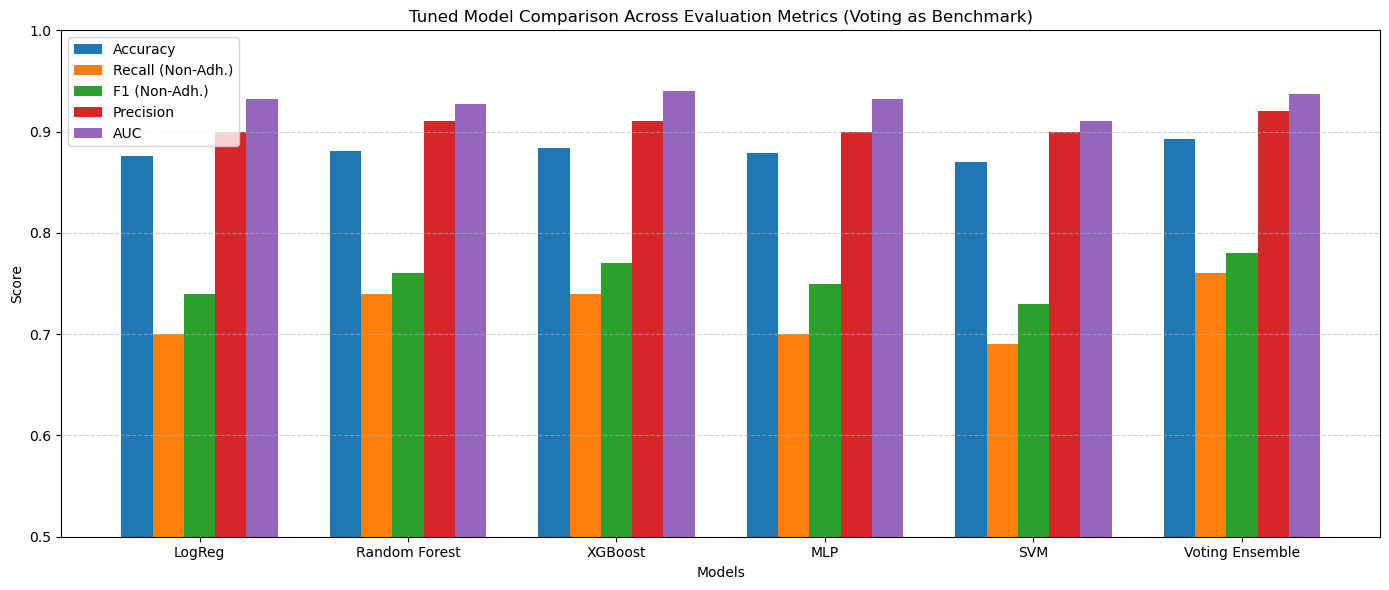

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LogReg', 'Random Forest', 'XGBoost', 'MLP', 'SVM', 'Voting Ensemble']

# Performance metrics
accuracy = [0.8757, 0.8812, 0.8840, 0.8785, 0.8702, 0.8923]
recall = [0.70, 0.74, 0.74, 0.70, 0.69, 0.76]
f1 = [0.74, 0.76, 0.77, 0.75, 0.73, 0.78]
precision = [0.90, 0.91, 0.91, 0.90, 0.90, 0.92]
auc = [0.9322, 0.9277, 0.9404, 0.9319, 0.9104, 0.9367]

# Bar width and positions
bar_width = 0.15
x = np.arange(len(models))

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(x - 2*bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x - bar_width, recall, width=bar_width, label='Recall (Non-Adh.)')
plt.bar(x, f1, width=bar_width, label='F1 (Non-Adh.)')
plt.bar(x + bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 2*bar_width, auc, width=bar_width, label='AUC')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Tuned Model Comparison Across Evaluation Metrics (Voting as Benchmark)')
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


In [32]:
# BUILDING THE CUSTOM MODEL

In [33]:
# Define the interaction features
def add_interactions(df):
    df['age_meds_interaction'] = df['age_scaled'] * df['total_count']
    df['price_burden_uninsured'] = df['estimated_price_scaled'] * (1 - df['insurance_status'])
    df['multi_morbidity_cost'] = df['has_chronic_comorbidity'] * df['estimated_price_scaled']
    df['gender_price_interaction'] = df['gender_encoded'] * df['estimated_price_scaled']
    df['age_chronic_combo'] = df['age_scaled'] * df['has_chronic_comorbidity']
    df['insurance_meds'] = df['insurance_status'] * df['total_count']
    return df

In [34]:
X_train_second = add_interactions(X_train_first)
X_val_second = add_interactions(X_val_first)
X_test_second = add_interactions(X_test_first)

C:\Users\geniu\AppData\Local\Temp\ipykernel_22392\103871135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_meds_interaction'] = df['age_scaled'] * df['total_count']
C:\Users\geniu\AppData\Local\Temp\ipykernel_22392\103871135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_burden_uninsured'] = df['estimated_price_scaled'] * (1 - df['insurance_status'])
C:\Users\geniu\AppData\Local\Temp\ipykernel_22392\103871135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [35]:
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_second, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_second)
y_val_proba_rf = rf_model.predict_proba(X_val_second)[:, 1]

# Evaluate
print("📈 Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Random Forest Performance on Validation Set:
Accuracy : 0.8538011695906432
Precision: 0.8914728682170543
Recall   : 0.9126984126984127
F1 Score : 0.9019607843137255
ROC AUC  : 0.8990299823633157

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.74      0.69      0.71        45
    Adherent (1)       0.89      0.91      0.90       126

        accuracy                           0.85       171
       macro avg       0.81      0.80      0.81       171
    weighted avg       0.85      0.85      0.85       171



In [36]:
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_second, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_second)
y_val_proba_xgb = xgb_model.predict_proba(X_val_second)[:, 1]

# Evaluate
print("📈 XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 XGBoost Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8939393939393939
Recall   : 0.9365079365079365
F1 Score : 0.9147286821705426
ROC AUC  : 0.8979717813051147

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.69      0.74        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.81      0.83       171
    weighted avg       0.87      0.87      0.87       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [37]:
from sklearn.neural_network import MLPClassifier

# Initialize and train
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_second, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_second)
y_val_proba_mlp = mlp_model.predict_proba(X_val_second)[:, 1]

# Evaluate
print("📈 Neural Network (MLP) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Neural Network (MLP) Performance on Validation Set:
Accuracy : 0.8596491228070176
Precision: 0.8863636363636364
Recall   : 0.9285714285714286
F1 Score : 0.9069767441860465
ROC AUC  : 0.9032627865961198

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.77      0.67      0.71        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.86       171
       macro avg       0.83      0.80      0.81       171
    weighted avg       0.86      0.86      0.86       171



C:\Users\geniu\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
from sklearn.svm import SVC

# Initialize and train
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_second, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_second)
y_val_proba_svm = svm_model.predict_proba(X_val_second)[:, 1]

# Evaluate
print("📈 SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 SVM (RBF) Performance on Validation Set:
Accuracy : 0.8771929824561403
Precision: 0.8888888888888888
Recall   : 0.9523809523809523
F1 Score : 0.9195402298850575
ROC AUC  : 0.8748677248677248

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.83      0.67      0.74        45
    Adherent (1)       0.89      0.95      0.92       126

        accuracy                           0.88       171
       macro avg       0.86      0.81      0.83       171
    weighted avg       0.87      0.88      0.87       171



In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_second, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_second)
y_val_proba = logreg.predict_proba(X_val_second)[:, 1]

# Evaluate
print("📈 Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.91331569664903

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171



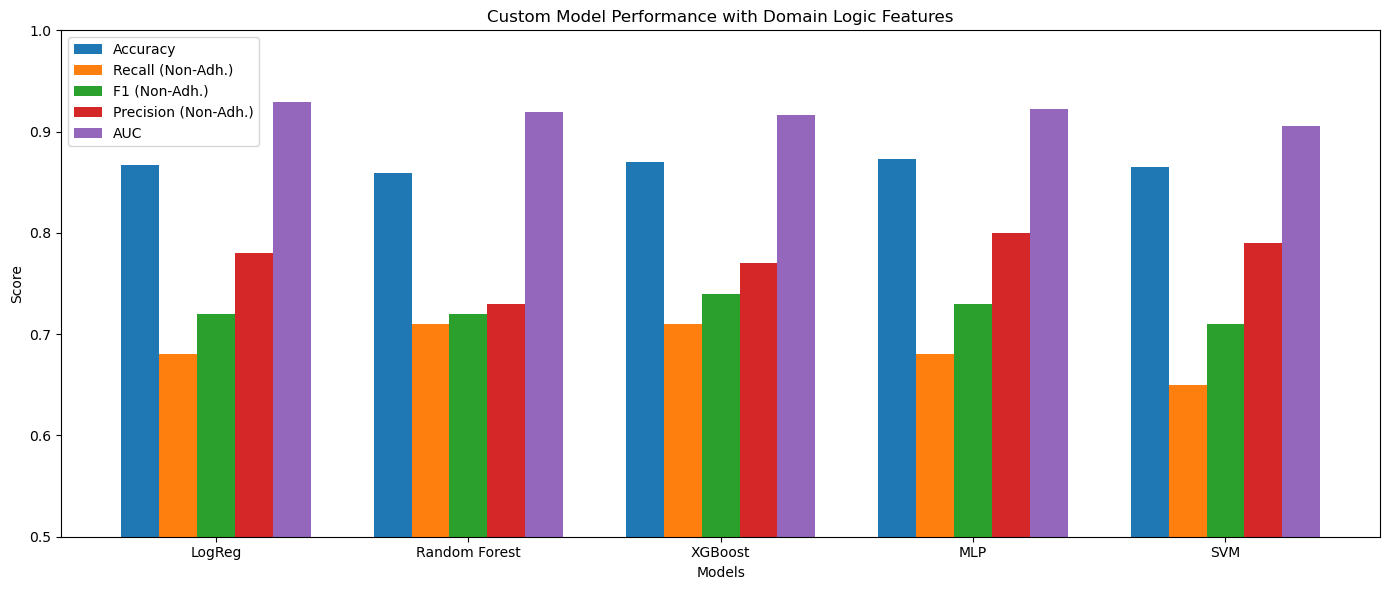

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LogReg', 'Random Forest', 'XGBoost', 'MLP', 'SVM']

# Evaluation metrics from the user-provided data
accuracy = [0.8674, 0.8591, 0.8702, 0.8729, 0.8646]
recall = [0.68, 0.71, 0.71, 0.68, 0.65]  # Recall for non-adherent (class 0)
f1 = [0.72, 0.72, 0.74, 0.73, 0.71]      # F1 for non-adherent (class 0)
precision = [0.78, 0.73, 0.77, 0.80, 0.79]  # Precision for non-adherent (class 0)
auc = [0.9290, 0.9194, 0.9162, 0.9228, 0.9055]

# Bar width and positions
x = np.arange(len(models))
bar_width = 0.15

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(x - 2*bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x - bar_width, recall, width=bar_width, label='Recall (Non-Adh.)')
plt.bar(x, f1, width=bar_width, label='F1 (Non-Adh.)')
plt.bar(x + bar_width, precision, width=bar_width, label='Precision (Non-Adh.)')
plt.bar(x + 2*bar_width, auc, width=bar_width, label='AUC')

# Labeling
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Custom Model Performance with Domain Logic Features')
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()

plt.show()


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_rf.fit(X_train_second, y_train)
# Best model
best_rf = grid_rf.best_estimator_
# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val_second)
y_val_proba_rf = best_rf.predict_proba(X_val_second)[:, 1]
# Evaluate
print("📈 Tuned Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned Random Forest Performance on Validation Set:
Accuracy : 0.8830409356725146
Precision: 0.8897058823529411
Recall   : 0.9603174603174603
F1 Score : 0.9236641221374046
ROC AUC  : 0.916225749559083

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.86      0.67      0.75        45
    Adherent (1)       0.89      0.96      0.92       126

        accuracy                           0.88       171
       macro avg       0.87      0.81      0.84       171
    weighted avg       0.88      0.88      0.88       171



In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Set up grid search
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_xgb.fit(X_train_second, y_train)
# Best model
best_xgb = grid_xgb.best_estimator_
# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val_second)
y_val_proba_xgb = best_xgb.predict_proba(X_val_second)[:, 1]
# Evaluate
print("📈 Tuned XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Tuned XGBoost Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.90625
Recall   : 0.9206349206349206
F1 Score : 0.9133858267716536
ROC AUC  : 0.9166666666666666

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.77      0.73      0.75        45
    Adherent (1)       0.91      0.92      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.83      0.83       171
    weighted avg       0.87      0.87      0.87       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# Set up grid search
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training set
grid_mlp.fit(X_train_second, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_second)
y_val_proba_mlp = best_mlp.predict_proba(X_val_second)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Tuned MLP Performance on Validation Set:
Accuracy : 0.8596491228070176
Precision: 0.8923076923076924
Recall   : 0.9206349206349206
F1 Score : 0.90625
ROC AUC  : 0.8999118165784833

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.76      0.69      0.72        45
    Adherent (1)       0.89      0.92      0.91       126

        accuracy                           0.86       171
       macro avg       0.82      0.80      0.81       171
    weighted avg       0.86      0.86      0.86       171



In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Set up grid search
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_logreg.fit(X_train_second, y_train)
# Best model
best_logreg = grid_logreg.best_estimator_
# Predict on validation set
y_val_pred_logreg = best_logreg.predict(X_val_second)
y_val_proba_logreg = best_logreg.predict_proba(X_val_second)[:, 1]
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.9131393298059965

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

# Set up grid search
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_svm.fit(X_train_second, y_train)
# Best model
best_svm = grid_svm.best_estimator_
# Predict on validation set
y_val_pred_svm = best_svm.predict(X_val_second)
y_val_proba_svm = best_svm.predict_proba(X_val_second)[:, 1]
# Evaluate
print("📈 Tuned SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned SVM (RBF) Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8939393939393939
Recall   : 0.9365079365079365
F1 Score : 0.9147286821705426
ROC AUC  : 0.8905643738977073

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.69      0.74        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.81      0.83       171
    weighted avg       0.87      0.87      0.87       171



In [46]:
# Evaluate
evaluate_model(best_xgb, X_test_second, y_test, model_name="Tuned XGBoost II")

📈 Tuned XGBoost II Performance:
Accuracy : 0.8840
Precision: 0.9097
Recall   : 0.9368
F1 Score : 0.9231
ROC AUC  : 0.9334

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.73      0.76        93
    Adherent (1)       0.91      0.94      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.83      0.84       362
    weighted avg       0.88      0.88      0.88       362



In [47]:
# Evaluate
evaluate_model(best_mlp, X_test_second, y_test, model_name="Tuned MLP II")

📈 Tuned MLP II Performance:
Accuracy : 0.8674
Precision: 0.9139
Recall   : 0.9071
F1 Score : 0.9104
ROC AUC  : 0.9085

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.74      0.75      0.74        93
    Adherent (1)       0.91      0.91      0.91       269

        accuracy                           0.87       362
       macro avg       0.83      0.83      0.83       362
    weighted avg       0.87      0.87      0.87       362



In [48]:
# Evaluate
evaluate_model(best_rf, X_test_second, y_test, model_name="Tuned RandomForest II")

📈 Tuned RandomForest II Performance:
Accuracy : 0.8757
Precision: 0.9029
Recall   : 0.9331
F1 Score : 0.9177
ROC AUC  : 0.9284

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.71      0.75        93
    Adherent (1)       0.90      0.93      0.92       269

        accuracy                           0.88       362
       macro avg       0.84      0.82      0.83       362
    weighted avg       0.87      0.88      0.87       362



In [49]:
# Evaluate
evaluate_model(best_logreg, X_test_second, y_test, model_name="Tuned LogisticReg II")

📈 Tuned LogisticReg II Performance:
Accuracy : 0.8702
Precision: 0.8964
Recall   : 0.9331
F1 Score : 0.9144
ROC AUC  : 0.9297

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        93
    Adherent (1)       0.90      0.93      0.91       269

        accuracy                           0.87       362
       macro avg       0.84      0.81      0.82       362
    weighted avg       0.87      0.87      0.87       362



In [50]:
# Evaluate
evaluate_model(best_svm, X_test_second, y_test, model_name="Tuned SVM II")

📈 Tuned SVM II Performance:
Accuracy : 0.8619
Precision: 0.8842
Recall   : 0.9368
F1 Score : 0.9097
ROC AUC  : 0.8990

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.65      0.71        93
    Adherent (1)       0.88      0.94      0.91       269

        accuracy                           0.86       362
       macro avg       0.83      0.79      0.81       362
    weighted avg       0.86      0.86      0.86       362



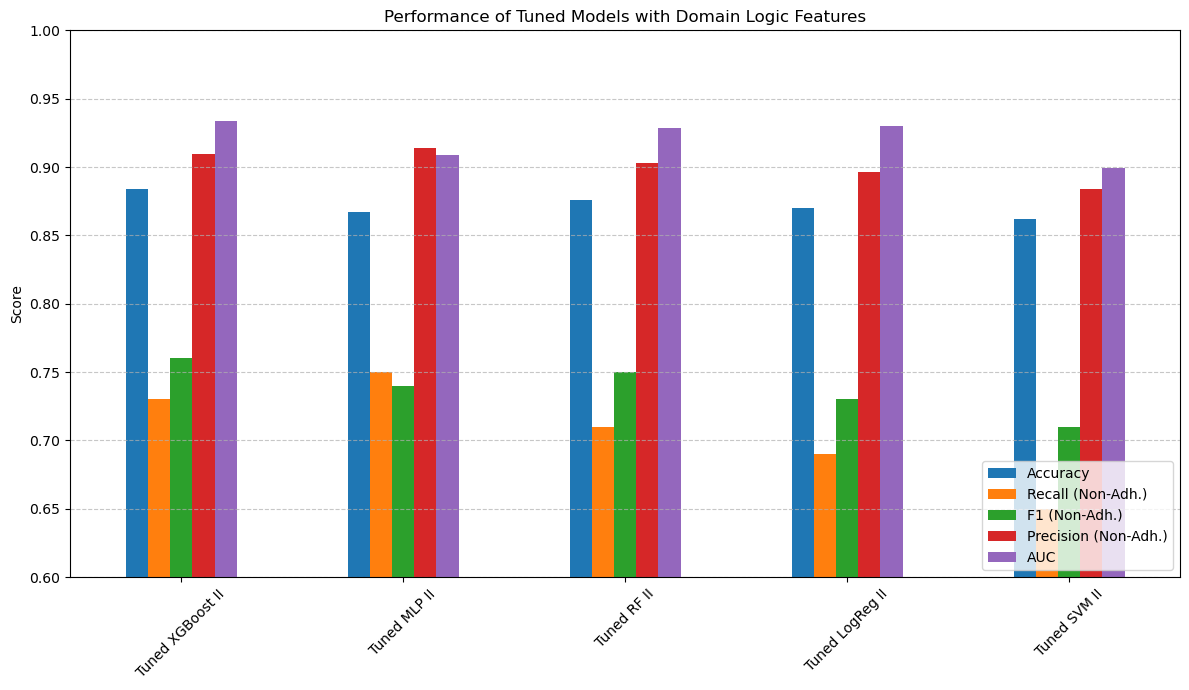

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Define performance data for tuned models after domain logic features
model_data = {
    "Tuned XGBoost II": [0.8840, 0.73, 0.76, 0.9097, 0.9334],
    "Tuned MLP II": [0.8674, 0.75, 0.74, 0.9139, 0.9085],
    "Tuned RF II": [0.8757, 0.71, 0.75, 0.9029, 0.9284],
    "Tuned LogReg II": [0.8702, 0.69, 0.73, 0.8964, 0.9297],
    "Tuned SVM II": [0.8619, 0.65, 0.71, 0.8842, 0.8990]
}

# Create a DataFrame
df = pd.DataFrame(model_data, index=["Accuracy", "Recall (Non-Adh.)", "F1 (Non-Adh.)", "Precision (Non-Adh.)", "AUC"]).T

# Plotting
ax = df.plot(kind='bar', figsize=(12, 7), rot=45)
plt.title("Performance of Tuned Models with Domain Logic Features")
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()


In [52]:
from sklearn.ensemble import VotingClassifier

# Create Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
    ],
    voting='soft'  # Use probability-based soft voting
)

# Fit on training data
voting_clf.fit(X_train_second, y_train)

# Evaluate
evaluate_model(voting_clf, X_val_second, y_val, model_name="Voting Ensemble")

📈 Voting Ensemble Performance:
Accuracy : 0.8538
Precision: 0.8915
Recall   : 0.9127
F1 Score : 0.9020
ROC AUC  : 0.9195

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.74      0.69      0.71        45
    Adherent (1)       0.89      0.91      0.90       126

        accuracy                           0.85       171
       macro avg       0.81      0.80      0.81       171
    weighted avg       0.85      0.85      0.85       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [53]:
# Evaluate
evaluate_model(voting_clf, X_test_second, y_test, model_name="Voting Ensemble")

📈 Voting Ensemble Performance:
Accuracy : 0.8923
Precision: 0.9228
Recall   : 0.9331
F1 Score : 0.9279
ROC AUC  : 0.9337

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.77      0.79        93
    Adherent (1)       0.92      0.93      0.93       269

        accuracy                           0.89       362
       macro avg       0.86      0.85      0.86       362
    weighted avg       0.89      0.89      0.89       362



In [54]:
# Define base learners
base_learners = [
        ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
]

# Define final estimator
final_estimator = LogisticRegression()
# Build stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5
)
# Fit on training data
stacked_clf.fit(X_train_second, y_train)
# Predict and evaluate on validation set
y_val_pred = stacked_clf.predict(X_val_second)
y_val_proba = stacked_clf.predict_proba(X_val_second)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)
# Print results
print("📈 Stacking Ensemble Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\

📈 Stacking Ensemble Performance:
Accuracy : 0.8596
Precision: 0.8923
Recall   : 0.9206
F1 Score : 0.9062
ROC AUC  : 0.9200

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.76      0.69      0.72        45
    Adherent (1)       0.89      0.92      0.91       126

        accuracy                           0.86       171
       macro avg       0.82      0.80      0.81       171
    weighted avg       0.86      0.86      0.86       171



In [55]:
# Evaluate
evaluate_model(stacked_clf, X_test_second, y_test, model_name="Stacked Ensemble")

📈 Stacked Ensemble Performance:
Accuracy : 0.8950
Precision: 0.9231
Recall   : 0.9368
F1 Score : 0.9299
ROC AUC  : 0.9336

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.77      0.79        93
    Adherent (1)       0.92      0.94      0.93       269

        accuracy                           0.90       362
       macro avg       0.87      0.86      0.86       362
    weighted avg       0.89      0.90      0.89       362



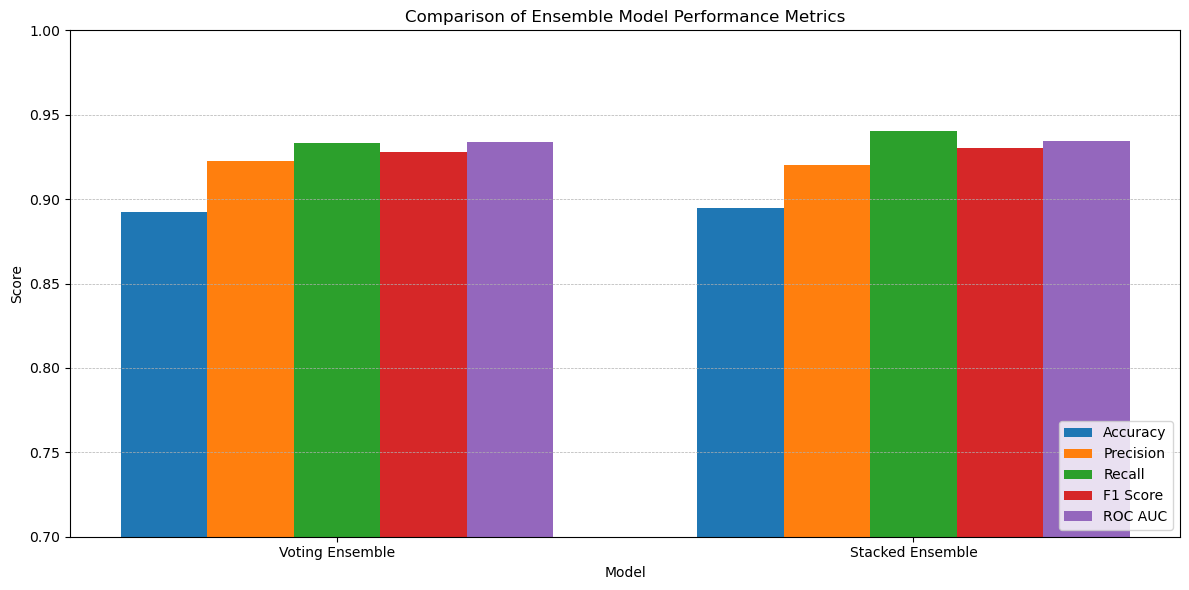

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Ensemble performance data
models = ['Voting Ensemble', 'Stacked Ensemble']
accuracy = [0.8923, 0.8950]
precision = [0.9228, 0.9200]
recall = [0.9331, 0.9405]
f1_score = [0.9279, 0.9301]
roc_auc = [0.9337, 0.9346]

# Grouped bar width and positions
bar_width = 0.15
index = np.arange(len(models))

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, precision, bar_width, label='Precision')
plt.bar(index + 2*bar_width, recall, bar_width, label='Recall')
plt.bar(index + 3*bar_width, f1_score, bar_width, label='F1 Score')
plt.bar(index + 4*bar_width, roc_auc, bar_width, label='ROC AUC')

# Chart formatting
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Comparison of Ensemble Model Performance Metrics')
plt.xticks(index + 2*bar_width, models)
plt.ylim(0.7, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


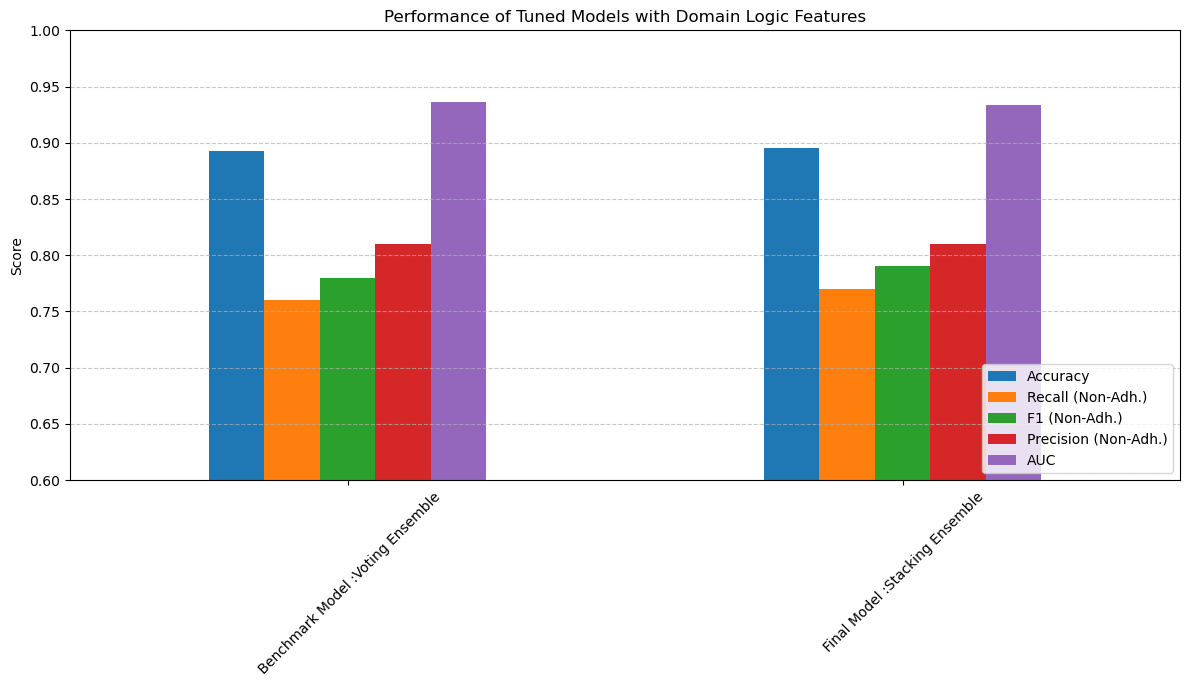

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Define performance data for tuned models after domain logic features
model_data = {
   
    " Benchmark Model :Voting Ensemble": [0.8923,0.76,0.78,0.81,0.9367],
    " Final Model :Stacking Ensemble": [0.895,0.77,0.79,0.81,0.9336]
}

# Create a DataFrame
df = pd.DataFrame(model_data, index=["Accuracy", "Recall (Non-Adh.)", "F1 (Non-Adh.)", "Precision (Non-Adh.)", "AUC"]).T

# Plotting
ax = df.plot(kind='bar', figsize=(12, 7), rot=45)
plt.title("Performance of Tuned Models with Domain Logic Features")
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()


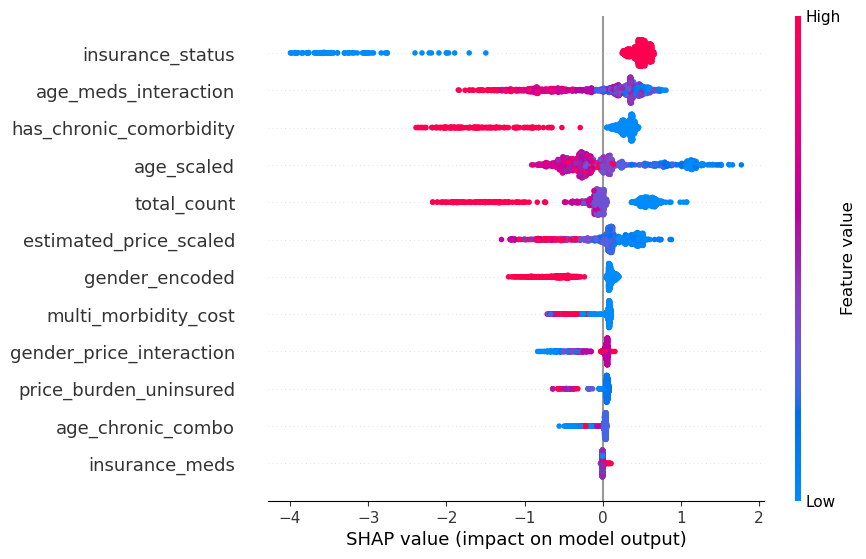

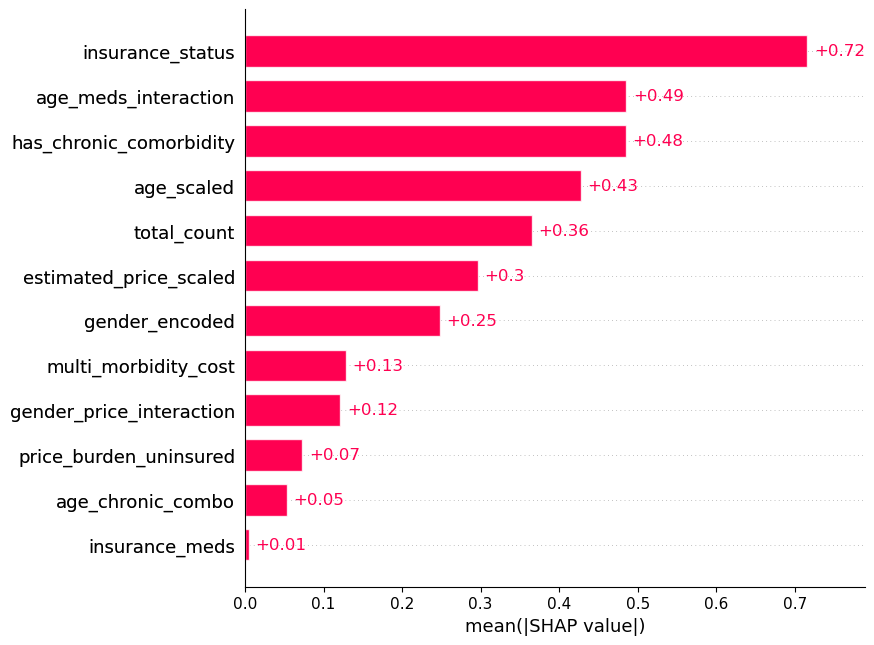

In [58]:
import shap
import matplotlib.pyplot as plt
# Step 2: Create SHAP Explainer
explainer = shap.Explainer(best_xgb, X_train_second)

# Step 3: Calculate SHAP values
shap_values = explainer(X_train_second)

# Step 4: Summary Plot (Global Importance)
plt.figure(figsize=(12, 7))
shap.plots.beeswarm(shap_values, max_display=12)

# Optional: Bar plot version
shap.plots.bar(shap_values, max_display=12)

In [59]:
# ABLATION STUDIES

TOP 12 FEATURES

In [119]:
selected_features = ['insurance_status','age_meds_interaction', 'has_chronic_comorbidity','age_scaled','total_count','estimated_price_scaled','gender_encoded','multi_morbidity_cost','gender_price_interaction','price_burden_uninsured','age_chronic_combo','insurance_meds']

In [121]:
X_train_first = X_train_second[selected_features]
X_val_first = X_val_second[selected_features]
X_test_first = X_test_second[selected_features]


In [123]:
X_train_second = add_interactions(X_train_processed)
X_val_second = add_interactions(X_val_processed)
X_test_second = add_interactions(X_test_processed)

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_first)
y_val_proba = logreg.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.91331569664903

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [127]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_first)
y_val_proba_rf = rf_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Random Forest Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8992248062015504
Recall   : 0.9206349206349206
F1 Score : 0.9098039215686274
ROC AUC  : 0.8962962962962963

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.76      0.71      0.74        45
    Adherent (1)       0.90      0.92      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.82      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [129]:
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_first)
y_val_proba_xgb = xgb_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 XGBoost Performance on Validation Set:
Accuracy : 0.8538011695906432
Precision: 0.8854961832061069
Recall   : 0.9206349206349206
F1 Score : 0.9027237354085603
ROC AUC  : 0.8992063492063492

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.75      0.67      0.71        45
    Adherent (1)       0.89      0.92      0.90       126

        accuracy                           0.85       171
       macro avg       0.82      0.79      0.80       171
    weighted avg       0.85      0.85      0.85       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [131]:
from sklearn.svm import SVC

# Initialize and train
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_first)
y_val_proba_svm = svm_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 SVM (RBF) Performance on Validation Set:
Accuracy : 0.8771929824561403
Precision: 0.8888888888888888
Recall   : 0.9523809523809523
F1 Score : 0.9195402298850575
ROC AUC  : 0.8748677248677248

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.83      0.67      0.74        45
    Adherent (1)       0.89      0.95      0.92       126

        accuracy                           0.88       171
       macro avg       0.86      0.81      0.83       171
    weighted avg       0.87      0.88      0.87       171



In [133]:
from sklearn.neural_network import MLPClassifier

# Initialize and train
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_first)
y_val_proba_mlp = mlp_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Neural Network (MLP) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Neural Network (MLP) Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8880597014925373
Recall   : 0.9444444444444444
F1 Score : 0.9153846153846154
ROC AUC  : 0.906084656084656

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.67      0.73        45
    Adherent (1)       0.89      0.94      0.92       126

        accuracy                           0.87       171
       macro avg       0.85      0.81      0.82       171
    weighted avg       0.87      0.87      0.87       171



In [135]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Set up grid search
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1', 
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_xgb.fit(X_train_first, y_train)
# Best model
best_xgb = grid_xgb.best_estimator_
# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val_first)
y_val_proba_xgb = best_xgb.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))


C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Tuned XGBoost Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8992248062015504
Recall   : 0.9206349206349206
F1 Score : 0.9098039215686274
ROC AUC  : 0.9127865961199294

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.76      0.71      0.74        45
    Adherent (1)       0.90      0.92      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.82      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [137]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

def evaluate_model(model, X, y_true, model_name="Model"):
    # Get predicted labels and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
  # Print results
    print(f"📈 {model_name} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))

In [139]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Set up grid search
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1
)

# Fit on training data
grid_logreg.fit(X_train_first, y_train)

# Best model
best_logreg = grid_logreg.best_estimator_
# Predict on validation set
y_val_pred_logreg = best_logreg.predict(X_val_first)
y_val_proba_logreg = best_logreg.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.9131393298059965

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_rf.fit(X_train_first, y_train)
# Best model
best_rf = grid_rf.best_estimator_
# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val_first)
y_val_proba_rf = best_rf.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))

📈 Tuned Random Forest Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.9149911816578483

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171



In [143]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

# Set up grid search
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_svm.fit(X_train_first, y_train)
# Best model
best_svm = grid_svm.best_estimator_
# Predict on validation set
y_val_pred_svm = best_svm.predict(X_val_first)
y_val_proba_svm = best_svm.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned SVM (RBF) Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8939393939393939
Recall   : 0.9365079365079365
F1 Score : 0.9147286821705426
ROC AUC  : 0.8905643738977073

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.69      0.74        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.81      0.83       171
    weighted avg       0.87      0.87      0.87       171



In [145]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# Set up grid search
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Tuned MLP Performance on Validation Set:
Accuracy : 0.8713450292397661
Precision: 0.8880597014925373
Recall   : 0.9444444444444444
F1 Score : 0.9153846153846154
ROC AUC  : 0.915079365079365

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.67      0.73        45
    Adherent (1)       0.89      0.94      0.92       126

        accuracy                           0.87       171
       macro avg       0.85      0.81      0.82       171
    weighted avg       0.87      0.87      0.87       171



In [147]:
# Evaluate
evaluate_model(best_mlp, X_test_first, y_test, model_name=" Tuned MLP")
# Evaluate
evaluate_model(best_xgb, X_test_first, y_test, model_name="Tuned XGBoost")
# Evaluate
evaluate_model(best_logreg, X_test_first, y_test, model_name="Tuned Logistic Regression")
# Evaluate
evaluate_model(best_rf, X_test_first, y_test, model_name="Tuned RF")

📈  Tuned MLP Performance:
Accuracy : 0.8674
Precision: 0.8905
Recall   : 0.9368
F1 Score : 0.9130
ROC AUC  : 0.9094

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.67      0.72        93
    Adherent (1)       0.89      0.94      0.91       269

        accuracy                           0.87       362
       macro avg       0.84      0.80      0.82       362
    weighted avg       0.86      0.87      0.86       362

📈 Tuned XGBoost Performance:
Accuracy : 0.8812
Precision: 0.9065
Recall   : 0.9368
F1 Score : 0.9214
ROC AUC  : 0.9324

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.72      0.76        93
    Adherent (1)       0.91      0.94      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.83      0.84       362
    weighted avg       0.88      0.88      0.88       362

📈 Tuned Log

In [149]:
from sklearn.ensemble import VotingClassifier

# Create Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
       ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
    ],
    voting='soft',  # Use probability-based soft voting
)


# Fit on training data
voting_clf.fit(X_train_first, y_train)

# Evaluate
evaluate_model(voting_clf, X_val_first, y_val, model_name="Voting Ensemble")

C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Voting Ensemble Performance:
Accuracy : 0.8713
Precision: 0.9000
Recall   : 0.9286
F1 Score : 0.9141
ROC AUC  : 0.9213

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.71      0.74        45
    Adherent (1)       0.90      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.82      0.83       171
    weighted avg       0.87      0.87      0.87       171



In [151]:
# Evaluate
evaluate_model(voting_clf, X_test_first, y_test, model_name="Voting Ensemble")

📈 Voting Ensemble Performance:
Accuracy : 0.8757
Precision: 0.9029
Recall   : 0.9331
F1 Score : 0.9177
ROC AUC  : 0.9329

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.71      0.75        93
    Adherent (1)       0.90      0.93      0.92       269

        accuracy                           0.88       362
       macro avg       0.84      0.82      0.83       362
    weighted avg       0.87      0.88      0.87       362



In [153]:
from sklearn.ensemble import StackingClassifier

# Define base learners
base_learners = [
   ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
]

# Define final estimator
final_estimator = LogisticRegression()
# Build stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5
)
# Fit on training data
stacked_clf.fit(X_train_first, y_train)
# Predict and evaluate on validation set
y_val_pred = stacked_clf.predict(X_val_first)
y_val_proba = stacked_clf.predict_proba(X_val_first)[:, 1]
# Evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)
# Print results
print("📈 Stacking Ensemble Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))


C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\

📈 Stacking Ensemble Performance:
Accuracy : 0.8772
Precision: 0.9008
Recall   : 0.9365
F1 Score : 0.9183
ROC AUC  : 0.9209

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.71      0.75        45
    Adherent (1)       0.90      0.94      0.92       126

        accuracy                           0.88       171
       macro avg       0.85      0.82      0.84       171
    weighted avg       0.87      0.88      0.87       171



In [155]:
# Evaluate voting on test data
evaluate_model(stacked_clf, X_test_first, y_test, model_name="Stacked Ensemble")


📈 Stacked Ensemble Performance:
Accuracy : 0.8729
Precision: 0.8940
Recall   : 0.9405
F1 Score : 0.9167
ROC AUC  : 0.9330

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.68      0.73        93
    Adherent (1)       0.89      0.94      0.92       269

        accuracy                           0.87       362
       macro avg       0.85      0.81      0.82       362
    weighted avg       0.87      0.87      0.87       362



TOP 7 FEATURES

In [157]:
selected_7_features = ['insurance_status','age_meds_interaction', 'has_chronic_comorbidity','age_scaled','total_count','estimated_price_scaled','gender_encoded']

In [159]:
X_train_first = X_train_second[selected_7_features]
X_val_first = X_val_second[selected_7_features]
X_test_first = X_test_second[selected_7_features]


In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_first)
y_val_proba = logreg.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_first)
y_val_proba_rf = rf_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_first)
y_val_proba_xgb = xgb_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.svm import SVC

# Initialize and train
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_first)
y_val_proba_svm = svm_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.neural_network import MLPClassifier

# Initialize and train
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_first)
y_val_proba_mlp = mlp_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Neural Network (MLP) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))


📈 Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8872180451127819
Recall   : 0.9365079365079365
F1 Score : 0.9111969111969112
ROC AUC  : 0.9164902998236332

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.67      0.72        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.80      0.82       171
    weighted avg       0.86      0.87      0.86       171

📈 Random Forest Performance on Validation Set:
Accuracy : 0.8596491228070176
Precision: 0.8984375
Recall   : 0.9126984126984127
F1 Score : 0.905511811023622
ROC AUC  : 0.8983245149911817

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.74      0.71      0.73        45
    Adherent (1)       0.90      0.91      0.91       126

        accuracy               

C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 XGBoost Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8931297709923665
Recall   : 0.9285714285714286
F1 Score : 0.9105058365758755
ROC AUC  : 0.8986772486772487

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.69      0.73        45
    Adherent (1)       0.89      0.93      0.91       126

        accuracy                           0.87       171
       macro avg       0.83      0.81      0.82       171
    weighted avg       0.86      0.87      0.86       171

📈 SVM (RBF) Performance on Validation Set:
Accuracy : 0.8538011695906432
Precision: 0.8796992481203008
Recall   : 0.9285714285714286
F1 Score : 0.9034749034749034
ROC AUC  : 0.8833333333333333

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.76      0.64      0.70        45
    Adherent (1)       0.88      0.93      0.90       126

        accuracy                     

In [163]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Set up grid search
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1', 
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_xgb.fit(X_train_first, y_train)
# Best model
best_xgb = grid_xgb.best_estimator_
# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val_first)
y_val_proba_xgb = best_xgb.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

def evaluate_model(model, X, y_true, model_name="Model"):
    # Get predicted labels and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
  # Print results
    print(f"📈 {model_name} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))
    from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Set up grid search
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1
)

# Fit on training data
grid_logreg.fit(X_train_first, y_train)

# Best model
best_logreg = grid_logreg.best_estimator_
# Predict on validation set
y_val_pred_logreg = best_logreg.predict(X_val_first)
y_val_proba_logreg = best_logreg.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_rf.fit(X_train_first, y_train)
# Best model
best_rf = grid_rf.best_estimator_
# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val_first)
y_val_proba_rf = best_rf.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

# Set up grid search
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_svm.fit(X_train_first, y_train)
# Best model
best_svm = grid_svm.best_estimator_
# Predict on validation set
y_val_pred_svm = best_svm.predict(X_val_first)
y_val_proba_svm = best_svm.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# Set up grid search
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))


C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Tuned XGBoost Performance on Validation Set:
Accuracy : 0.8596491228070176
Precision: 0.8984375
Recall   : 0.9126984126984127
F1 Score : 0.905511811023622
ROC AUC  : 0.9085537918871253

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.74      0.71      0.73        45
    Adherent (1)       0.90      0.91      0.91       126

        accuracy                           0.86       171
       macro avg       0.82      0.81      0.82       171
    weighted avg       0.86      0.86      0.86       171

📈 Tuned Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8872180451127819
Recall   : 0.9365079365079365
F1 Score : 0.9111969111969112
ROC AUC  : 0.9164902998236332

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.67      0.72        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy         

In [165]:
# Evaluate
evaluate_model(best_xgb, X_test_first, y_test, model_name="Tuned XGBoost")
# Evaluate
evaluate_model(best_logreg, X_test_first, y_test, model_name="Tuned Logistic Regression")
# Evaluate
evaluate_model(best_rf, X_test_first, y_test, model_name="Tuned RF")
# Evaluate
evaluate_model(best_svm, X_test_first, y_test, model_name="Tuned SVM")


📈 Tuned XGBoost Performance:
Accuracy : 0.8923
Precision: 0.9228
Recall   : 0.9331
F1 Score : 0.9279
ROC AUC  : 0.9292

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.77      0.79        93
    Adherent (1)       0.92      0.93      0.93       269

        accuracy                           0.89       362
       macro avg       0.86      0.85      0.86       362
    weighted avg       0.89      0.89      0.89       362

📈 Tuned Logistic Regression Performance:
Accuracy : 0.8757
Precision: 0.9000
Recall   : 0.9368
F1 Score : 0.9180
ROC AUC  : 0.9314

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.70      0.74        93
    Adherent (1)       0.90      0.94      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.82      0.83       362
    weighted avg       0.87      0.88      0.87       3

In [167]:
from sklearn.ensemble import VotingClassifier

# Create Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
       ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
    ],
    voting='soft',  # Use probability-based soft voting
)


# Fit on training data
voting_clf.fit(X_train_first, y_train)

# Evaluate
evaluate_model(voting_clf, X_val_first, y_val, model_name="Voting Ensemble")
from sklearn.ensemble import StackingClassifier

# Define base learners
base_learners = [
   ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
]

# Define final estimator
final_estimator = LogisticRegression()
# Build stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5
)
# Fit on training data
stacked_clf.fit(X_train_first, y_train)
# Predict and evaluate on validation set
y_val_pred = stacked_clf.predict(X_val_first)
y_val_proba = stacked_clf.predict_proba(X_val_first)[:, 1]
# Evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)
# Print results
print("📈 Stacking Ensemble Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))
# Evaluate voting on test data
evaluate_model(stacked_clf, X_test_first, y_test, model_name="Stacked Ensemble")


C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Voting Ensemble Performance:
Accuracy : 0.8713
Precision: 0.8939
Recall   : 0.9365
F1 Score : 0.9147
ROC AUC  : 0.9170

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.69      0.74        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.81      0.83       171
    weighted avg       0.87      0.87      0.87       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\

📈 Stacking Ensemble Performance:
Accuracy : 0.8713
Precision: 0.8881
Recall   : 0.9444
F1 Score : 0.9154
ROC AUC  : 0.9184

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.67      0.73        45
    Adherent (1)       0.89      0.94      0.92       126

        accuracy                           0.87       171
       macro avg       0.85      0.81      0.82       171
    weighted avg       0.87      0.87      0.87       171

📈 Stacked Ensemble Performance:
Accuracy : 0.8757
Precision: 0.8972
Recall   : 0.9405
F1 Score : 0.9183
ROC AUC  : 0.9347

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.80      0.69      0.74        93
    Adherent (1)       0.90      0.94      0.92       269

        accuracy                           0.88       362
       macro avg       0.85      0.81      0.83       362
    weighted avg       0.87      0.88      0.87       362



In [169]:
# TOP 5 FEATURES

In [171]:
selected_5_features = ['insurance_status','age_meds_interaction', 'has_chronic_comorbidity','age_scaled','total_count']

In [173]:
X_train_first = X_train_second[selected_5_features]
X_val_first = X_val_second[selected_5_features]
X_test_first = X_test_second[selected_5_features]


In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_first)
y_val_proba = logreg.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_first, y_train)
# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_first)
y_val_proba_rf = rf_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_first)
y_val_proba_xgb = xgb_model.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.svm import SVC

# Initialize and train
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_first)
y_val_proba_svm = svm_model.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.neural_network import MLPClassifier
# Initialize and train
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_first)
y_val_proba_mlp = mlp_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Neural Network (MLP) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
# Set up grid search
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1', 
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_xgb.fit(X_train_first, y_train)
# Best model
best_xgb = grid_xgb.best_estimator_
# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val_first)
y_val_proba_xgb = best_xgb.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
def evaluate_model(model, X, y_true, model_name="Model"):
    # Get predicted labels and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
     # Print results
    print(f"📈 {model_name} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))
    from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}
# Set up grid search
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1
)
# Fit on training data
grid_logreg.fit(X_train_first, y_train)

# Best model
best_logreg = grid_logreg.best_estimator_
# Predict on validation set
y_val_pred_logreg = best_logreg.predict(X_val_first)
y_val_proba_logreg = best_logreg.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_rf.fit(X_train_first, y_train)
# Best model
best_rf = grid_rf.best_estimator_
# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val_first)
y_val_proba_rf = best_rf.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

# Set up grid search
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_svm.fit(X_train_first, y_train)
# Best model
best_svm = grid_svm.best_estimator_
# Predict on validation set
y_val_pred_svm = best_svm.predict(X_val_first)
y_val_proba_svm = best_svm.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}
# Set up grid search
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))
# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import VotingClassifier

# Create Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
       ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
    ],
    voting='soft',  # Use probability-based soft voting
)
# Fit on training data
voting_clf.fit(X_train_first, y_train)

# Evaluate
evaluate_model(voting_clf, X_val_first, y_val, model_name="Voting Ensemble")
from sklearn.ensemble import StackingClassifier
# Define base learners
base_learners = [
   ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
]

# Define final estimator
final_estimator = LogisticRegression()
# Build stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5
)
# Fit on training data
stacked_clf.fit(X_train_first, y_train)
# Predict and evaluate on validation set
y_val_pred = stacked_clf.predict(X_val_first)
y_val_proba = stacked_clf.predict_proba(X_val_first)[:, 1]
# Evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)
# Print results
print("📈 Stacking Ensemble Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))
# Evaluate voting on test data
evaluate_model(stacked_clf, X_test_first, y_test, model_name="Stacked Ensemble")


📈 Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8814814814814815
Recall   : 0.9444444444444444
F1 Score : 0.9118773946360154
ROC AUC  : 0.9026455026455026

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.64      0.72        45
    Adherent (1)       0.88      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.79      0.81       171
    weighted avg       0.86      0.87      0.86       171

📈 Random Forest Performance on Validation Set:
Accuracy : 0.8421052631578947
Precision: 0.8837209302325582
Recall   : 0.9047619047619048
F1 Score : 0.8941176470588236
ROC AUC  : 0.8670194003527336

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.71      0.67      0.69        45
    Adherent (1)       0.88      0.90      0.89       126

        accuracy     

C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 SVM (RBF) Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8872180451127819
Recall   : 0.9365079365079365
F1 Score : 0.9111969111969112
ROC AUC  : 0.8650793650793651

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.67      0.72        45
    Adherent (1)       0.89      0.94      0.91       126

        accuracy                           0.87       171
       macro avg       0.84      0.80      0.82       171
    weighted avg       0.86      0.87      0.86       171

📈 Neural Network (MLP) Performance on Validation Set:
Accuracy : 0.8596491228070176
Precision: 0.8805970149253731
Recall   : 0.9365079365079365
F1 Score : 0.9076923076923077
ROC AUC  : 0.891005291005291

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.78      0.64      0.71        45
    Adherent (1)       0.88      0.94      0.91       126

        accuracy         

C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Tuned XGBoost Performance on Validation Set:
Accuracy : 0.8596491228070176
Precision: 0.8695652173913043
Recall   : 0.9523809523809523
F1 Score : 0.9090909090909091
ROC AUC  : 0.8899470899470899

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.82      0.60      0.69        45
    Adherent (1)       0.87      0.95      0.91       126

        accuracy                           0.86       171
       macro avg       0.84      0.78      0.80       171
    weighted avg       0.86      0.86      0.85       171

📈 Tuned Logistic Regression Performance on Validation Set:
Accuracy : 0.8654970760233918
Precision: 0.8814814814814815
Recall   : 0.9444444444444444
F1 Score : 0.9118773946360154
ROC AUC  : 0.9026455026455026

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.81      0.64      0.72        45
    Adherent (1)       0.88      0.94      0.91       126

        accurac

C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Voting Ensemble Performance:
Accuracy : 0.8830
Precision: 0.8897
Recall   : 0.9603
F1 Score : 0.9237
ROC AUC  : 0.9015

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.86      0.67      0.75        45
    Adherent (1)       0.89      0.96      0.92       126

        accuracy                           0.88       171
       macro avg       0.87      0.81      0.84       171
    weighted avg       0.88      0.88      0.88       171



C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\geniu\anaconda3\Lib\site-packages\

📈 Stacking Ensemble Performance:
Accuracy : 0.8830
Precision: 0.8897
Recall   : 0.9603
F1 Score : 0.9237
ROC AUC  : 0.9016

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.86      0.67      0.75        45
    Adherent (1)       0.89      0.96      0.92       126

        accuracy                           0.88       171
       macro avg       0.87      0.81      0.84       171
    weighted avg       0.88      0.88      0.88       171

📈 Stacked Ensemble Performance:
Accuracy : 0.8619
Precision: 0.8815
Recall   : 0.9405
F1 Score : 0.9101
ROC AUC  : 0.9118

📊 Classification Report:
                  precision    recall  f1-score   support

Non-Adherent (0)       0.79      0.63      0.70        93
    Adherent (1)       0.88      0.94      0.91       269

        accuracy                           0.86       362
       macro avg       0.83      0.79      0.81       362
    weighted avg       0.86      0.86      0.86       362



In [ ]:
TOP 3 FEATURES

In [177]:
selected_3_features = ['insurance_status','age_meds_interaction', 'has_chronic_comorbidity']

In [179]:
X_train_first = X_train_second[selected_3_features]
X_val_first = X_val_second[selected_3_features]
X_test_first = X_test_second[selected_3_features]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize and train
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_first)
y_val_proba = logreg.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_first, y_train)
# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_first)
y_val_proba_rf = rf_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from xgboost import XGBClassifier

# Initialize and train
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_first)
y_val_proba_xgb = xgb_model.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.svm import SVC

# Initialize and train
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_first)
y_val_proba_svm = svm_model.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.neural_network import MLPClassifier
 Initialize and train
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_first, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_first)
y_val_proba_mlp = mlp_model.predict_proba(X_val_first)[:, 1]

# Evaluate
print("📈 Neural Network (MLP) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
# Set up grid search
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1', 
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_xgb.fit(X_train_first, y_train)
# Best model
best_xgb = grid_xgb.best_estimator_
# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val_first)
y_val_proba_xgb = best_xgb.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned XGBoost Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb))
print("Recall   :", recall_score(y_val, y_val_pred_xgb))
print("F1 Score :", f1_score(y_val, y_val_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_xgb))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
def evaluate_model(model, X, y_true, model_name="Model"):
    # Get predicted labels and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
     # Print results
    print(f"📈 {model_name} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))
    from sklearn.model_selection import GridSearchCV
# Define hyperparameter grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Set up grid search
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1
)
# Fit on training data
grid_logreg.fit(X_train_first, y_train)

# Best model
best_logreg = grid_logreg.best_estimator_
# Predict on validation set
y_val_pred_logreg = best_logreg.predict(X_val_first)
y_val_proba_logreg = best_logreg.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Evaluate
print("📈 Tuned Logistic Regression Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_logreg))
print("Precision:", precision_score(y_val, y_val_pred_logreg))
print("Recall   :", recall_score(y_val, y_val_pred_logreg))
print("F1 Score :", f1_score(y_val, y_val_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_logreg))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_logreg, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
# Set up grid search
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training data
grid_rf.fit(X_train_first, y_train)
# Best model
best_rf = grid_rf.best_estimator_
# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val_first)
y_val_proba_rf = best_rf.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned Random Forest Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall   :", recall_score(y_val, y_val_pred_rf))
print("F1 Score :", f1_score(y_val, y_val_pred_rf))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_rf))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}
# Set up grid search
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_svm.fit(X_train_first, y_train)
# Best model
best_svm = grid_svm.best_estimator_
# Predict on validation set
y_val_pred_svm = best_svm.predict(X_val_first)
y_val_proba_svm = best_svm.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned SVM (RBF) Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_svm))
print("Precision:", precision_score(y_val, y_val_pred_svm))
print("Recall   :", recall_score(y_val, y_val_pred_svm))
print("F1 Score :", f1_score(y_val, y_val_pred_svm))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_svm))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_svm, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# Set up grid search
grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))
# Fit on training set
grid_mlp.fit(X_train_first, y_train)
# Best model
best_mlp = grid_mlp.best_estimator_
# Predict on validation set
y_val_pred_mlp = best_mlp.predict(X_val_first)
y_val_proba_mlp = best_mlp.predict_proba(X_val_first)[:, 1]
# Evaluate
print("📈 Tuned MLP Performance on Validation Set:")
print("Accuracy :", accuracy_score(y_val, y_val_pred_mlp))
print("Precision:", precision_score(y_val, y_val_pred_mlp))
print("Recall   :", recall_score(y_val, y_val_pred_mlp))
print("F1 Score :", f1_score(y_val, y_val_pred_mlp))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_mlp))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred_mlp, target_names=['Non-Adherent (0)', 'Adherent (1)']))
from sklearn.ensemble import VotingClassifier
# Create Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
       ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
    ],
    voting='soft',  # Use probability-based soft voting
)


# Fit on training data
voting_clf.fit(X_train_first, y_train)

# Evaluate
evaluate_model(voting_clf, X_val_first, y_val, model_name="Voting Ensemble")
from sklearn.ensemble import StackingClassifier
# Define base learners
base_learners = [
   ('mlp', best_mlp),
        ('xgb', best_xgb),
        ('logreg', best_logreg)
]
# Define final estimator
final_estimator = LogisticRegression()
# Build stacking classifier
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5
)
# Fit on training data
stacked_clf.fit(X_train_first, y_train)
# Predict and evaluate on validation set
y_val_pred = stacked_clf.predict(X_val_first)
y_val_proba = stacked_clf.predict_proba(X_val_first)[:, 1]
# Evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)
# Print results
print("📈 Stacking Ensemble Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Adherent (0)", "Adherent (1)"]))
